# Flight Price Prediction Case Study

## Context and Problem
 - The objective of this project is to predict the price of a flight with a set of relevant flight details is provided
 - The flight details have information related to flight timings, source and destination details, route details, stops in       between, etc.
 - The dataset consists of about one year of information about various flights and their respective prices.
 
## Data Information

The data at hand has eleven features about the spending on advertising and the target variable is the net sales. Attributes are:

- Airline - Company that provides air transport services for traveling passengers. (Independent Variable)
- Source  - From where the flight is takes off.(Independent Variable)
- Destination - To where the flight is going.(Independent Variable)
- Route   - What is the route of each flight.(Independent Variable)
- Dep Time - Departure Time of the flight.(Independent Variable)
- Arrival Time - Arrival Time of the flight.(Independent Variable)
- Duration - Total duration of the flight.(Independent Variable)
- Total Stops - Number of stops between source and destination.(Independent Variable)
- Additional info - Additional information about the flight is given.(Independent Variable)
- Price - Price of each flight.(Dependent Variable)

In [133]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the required libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import pyplot
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error
from collections import Counter
from keras import callbacks
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout,InputLayer
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import backend
from random import shuffle
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
import warnings
warnings.filterwarnings("ignore")

KeyboardInterrupt: 

#### Reading the Dataset 

In [135]:
#Since data is in form of excel file we have to use pandas pd.read_excel to load the data.
data = pd.read_excel('/content/drive/MyDrive/Data.xlsx')

#### Print the first five rows of the data

In [136]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [137]:
#Information about the data
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10682 entries, 0 to 10681
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10681 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10681 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.1+ KB


In [138]:
#Checking the shape of the data
data.shape

(10682, 11)

In [139]:
#finding the null values
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [140]:
data[data['Route'].isna()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9038,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


* Those 2 values belong to a single row so we can drop that row

In [141]:
#drop the nullvalues
data.dropna(inplace=True)

In [142]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [143]:
#Checking the dtypes of the variables in the data
data.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

* The dtypes of 'Date_of_Journey','Dep_Time',and 'Arrival_Time' is in object, so firstly converting it into datetime dtype 

In [144]:
# Creating a function to convert those columns into datetime dtype
def To_Datetime(data,column):
    data[column] = pd.to_datetime(data[column])
    return data[column]

In [145]:
# convert the columns we want into datetime
To_Datetime(data,'Date_of_Journey')
To_Datetime(data,'Dep_Time')
To_Datetime(data,'Arrival_Time')

0       2022-03-22 01:10:00
1       2022-01-24 13:15:00
2       2022-06-10 04:25:00
3       2022-01-24 23:30:00
4       2022-01-24 21:35:00
                ...        
10677   2022-01-24 22:25:00
10678   2022-01-24 23:20:00
10679   2022-01-24 11:20:00
10680   2022-01-24 14:10:00
10681   2022-01-24 19:15:00
Name: Arrival_Time, Length: 10681, dtype: datetime64[ns]

* We can extract day and month from Date_of_journey and store it in two other columns.

In [146]:
# creating new columns
data['Day_of_Journey'] = data['Date_of_Journey'].dt.day
data['Month_of_Journey'] = data['Date_of_Journey'].dt.month

* Now using Dep_Time and Arrival_Time we can extract hour and minute from both the variables

In [147]:
data['Dep_hour'] = data['Dep_Time'].dt.hour
data['Dep_minute'] = data['Dep_Time'].dt.minute

data['Arrival_hour'] = data['Arrival_Time'].dt.hour
data['Arrival_minute'] = data['Arrival_Time'].dt.minute

* After extacting required data from Date_of_Journey, Dep_Time, and Arrival_Time we can drop these variables 

In [148]:
data.drop(['Date_of_Journey','Dep_Time','Arrival_Time'],axis=1,inplace=True)

* Lets Apply pre-processing on duration column,Separate Duration hours and minute from duration

In [149]:
duration=list(data['Duration'])
for i in range(len(duration)):
    if len(duration[i].split(' '))==2:
        pass
    else:
        if 'h' in duration[i]: # Check if duration contains only hour
             duration[i]=duration[i] + ' 0m' # Adds 0 minute
        else:
             duration[i]='0h '+ duration[i]
            
duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

In [150]:
# Adding duration_hours and duration_mins list to train_data dataframe

data["Duration_hours"] = duration_hours
data["Duration_mins"] = duration_mins

In [151]:
#Dropping Duration variable as we have extracted both hours and mins from it
data.drop(["Duration"], axis = 1, inplace = True)

In [152]:
data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,5,1,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,6,9,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,5,12,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,3,1,16,50,21,35,4,45


In [153]:
data.dtypes

Airline             object
Source              object
Destination         object
Route               object
Total_Stops         object
Additional_Info     object
Price                int64
Day_of_Journey       int64
Month_of_Journey     int64
Dep_hour             int64
Dep_minute           int64
Arrival_hour         int64
Arrival_minute       int64
Duration_hours       int64
Duration_mins        int64
dtype: object

### Exploratory Data Analysis

#### Univariate Analysis

In [154]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### `Airline`

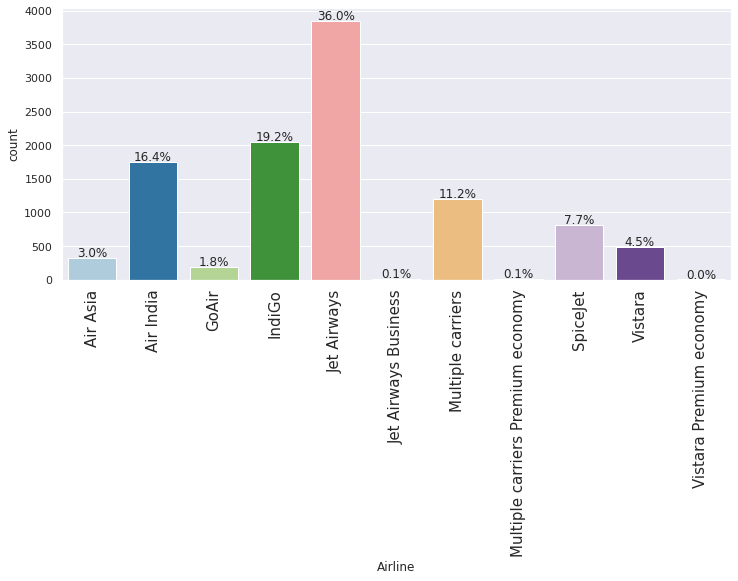

In [155]:
labeled_barplot(data, "Airline", perc=True)

* From the above bar plot we can see most of them have opted Jet Airways as their Airline for transportation

### `Total Stops`

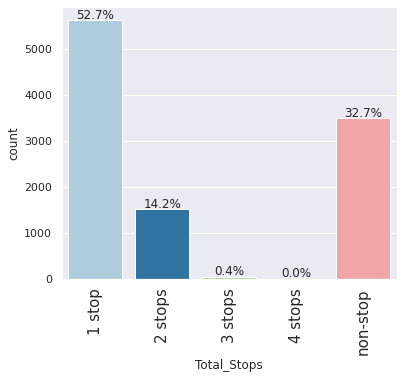

In [158]:
labeled_barplot(data, "Total_Stops", perc=True)

* Most of the airlines runs with maximum of single stop during the journey  

### `Source`

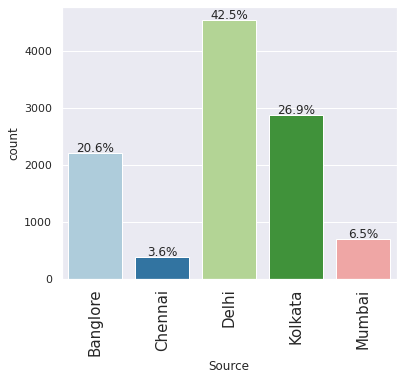

In [159]:
labeled_barplot(data, "Source", perc=True)

* Most of flights are departing from the capital city of India(Delhi) 

### `Destination`

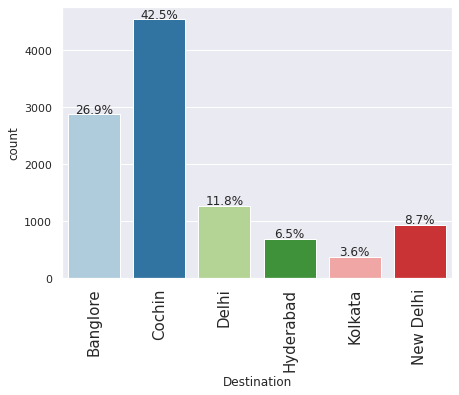

In [160]:
labeled_barplot(data, "Destination", perc=True)

In [161]:
#New Delhi and Delhi can be the same so we will merge them
data['Destination'].replace('New Delhi','Delhi',inplace=True)

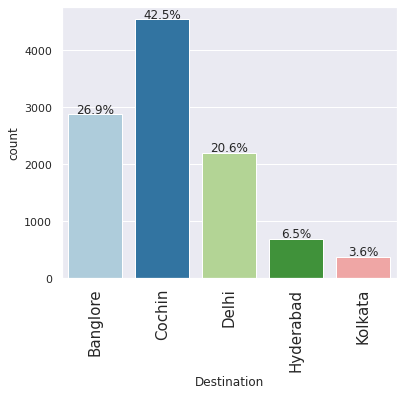

In [162]:
labeled_barplot(data, "Destination", perc=True)

* From the above plot we can observe most of the filghts are going to Cochin 

### `Additional_Info`

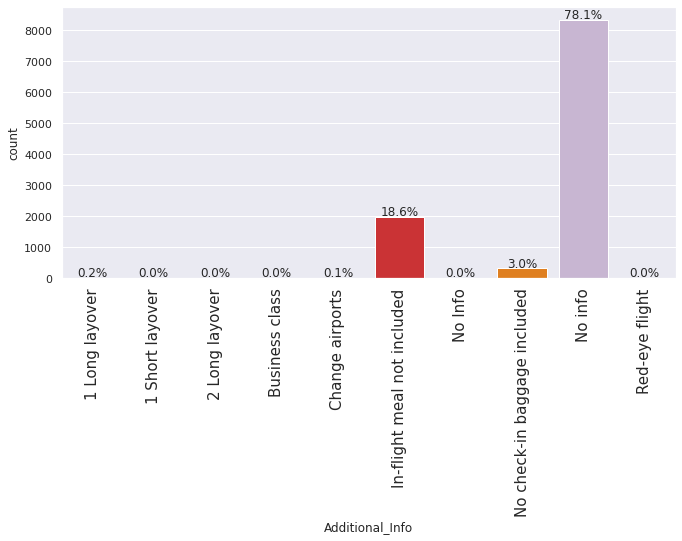

In [163]:
labeled_barplot(data, "Additional_Info", perc=True)

* As most of the Additional_Info (80%) variable contains No_info so we can drop this from the data

In [38]:
data['Route'].value_counts()

DEL → BOM → COK                      2376
BLR → DEL                            1552
CCU → BOM → BLR                       979
CCU → BLR                             724
BOM → HYD                             621
                                     ... 
BOM → BLR → CCU → BBI → HYD             1
BOM → CCU → HYD                         1
BLR → HBX → BOM → BHO → DEL             1
CCU → RPR → HYD → BLR                   1
BLR → CCU → BBI → HYD → VGA → DEL       1
Name: Route, Length: 127, dtype: int64

* Route and Total_Stops are related to each other so we can drop Route variable

In [39]:
data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [40]:
data.head()

,Airline,Source,Destination,Total_Stops,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,non-stop,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2 stops,7662,5,1,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2 stops,13882,6,9,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1 stop,6218,5,12,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1 stop,13302,3,1,16,50,21,35,4,45


In [41]:
# As this is case of Ordinal Categorical type we perform LabelEncoder
# Here Values are assigned with corresponding keys

data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

### Bivariate analysis

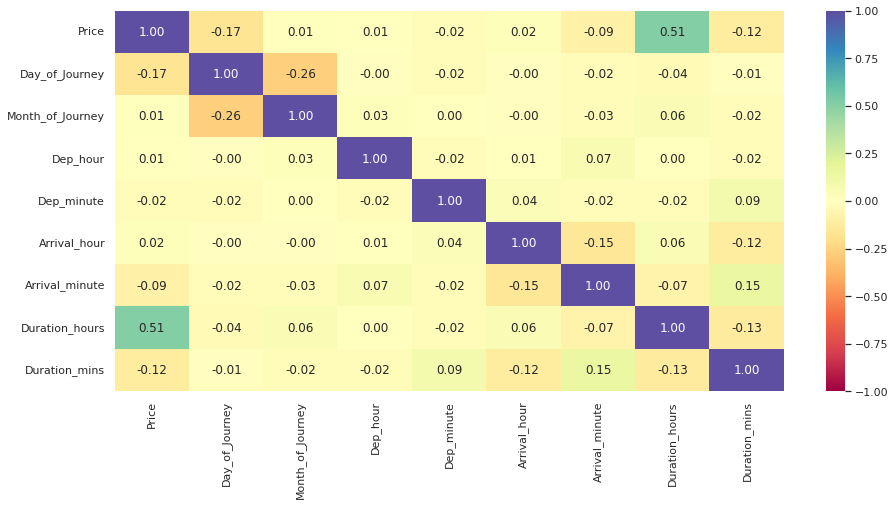

In [165]:
plt.figure(figsize=(15, 7))
sns.heatmap(
    data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

* Day of Journey is highly correlated to target column

### `Airline` vs `Price`

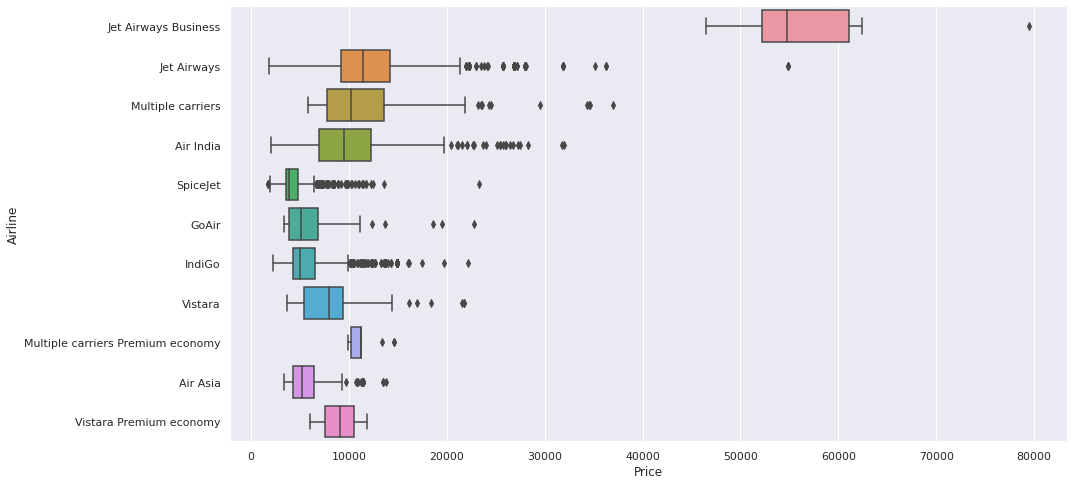

In [174]:
plt.figure(figsize=(15,8))
a=sns.boxplot(x='Price',y='Airline',data=data.sort_values('Price',ascending=False),orient="h")

- Jet Airways Business is charging high price when comparing with other Airlines 
- Apart from the Jet Airways Business Airline almost all are having similar median.

In [ ]:
Highest_airline_price= data[data['Airline']=='Jet Airways Business']
Highest_airline_price

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Duration_hours,Duration_mins
657,Jet Airways Business,Banglore,New Delhi,BLR → BOM → DEL,1 stop,No info,52229,3,1,5,45,10,45,5,0
2923,Jet Airways Business,Banglore,New Delhi,BLR → BOM → DEL,1 stop,Business class,79512,3,1,5,45,11,25,5,40
5371,Jet Airways Business,Banglore,New Delhi,BLR → BOM → DEL,1 stop,Business class,62427,3,1,5,45,12,25,6,40
7350,Jet Airways Business,Delhi,Cochin,DEL → ATQ → BOM → COK,2 stops,No info,46490,3,3,20,5,4,25,8,20
9714,Jet Airways Business,Delhi,Cochin,DEL → ATQ → BOM → COK,2 stops,No info,52285,3,6,20,5,4,25,8,20
10363,Jet Airways Business,Banglore,New Delhi,BLR → MAA → DEL,1 stop,Business class,57209,3,1,9,45,14,25,4,40


* We can see the price of the Jet Airways Business Airline having an average price of 50 thousand Rupees 

### `Total Stops` vs `Price`

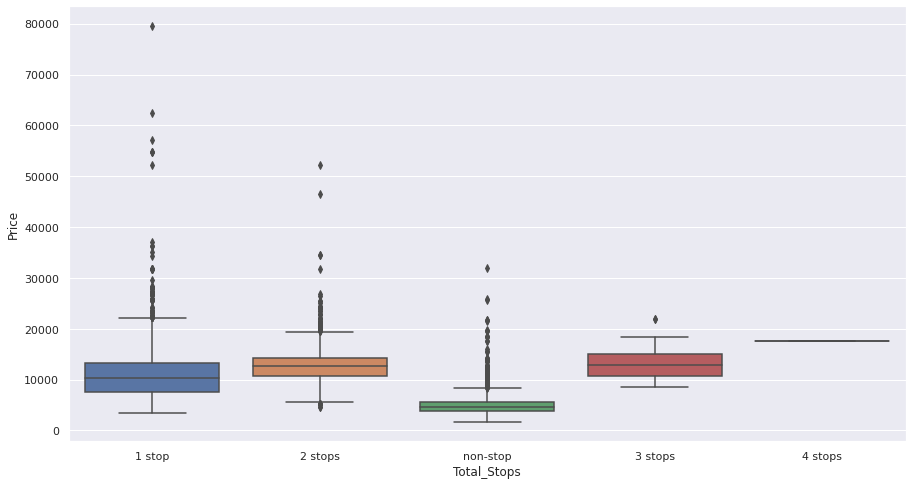

In [175]:
plt.figure(figsize=(15,8))
sns.boxplot(x='Total_Stops',y='Price',data=data.sort_values('Price',ascending=False))

* Prices of Airline having different stops are almost equal and mainly the price depends on which Airline we are choosing to travell

### `Source` vs `Price`

<Figure size 1080x1080 with 0 Axes>

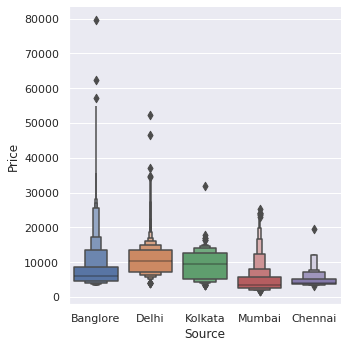

In [176]:
plt.figure(figsize=(15,15))
sns.catplot(x='Source',y='Price',data=data.sort_values('Price',ascending=False),kind='boxen')

In [177]:
Banglore= data[data['Source']=='Banglore']
Delhi= data[data['Source']=='Delhi']
Kolkata= data[data['Source']=='Kolkata']
Mumbai= data[data['Source']=='Mumbai']
Chennai= data[data['Source']=='Chennai']

In [178]:
print(Banglore["Price"].mean())
print(Delhi["Price"].mean())
print(Kolkata["Price"].mean())
print(Mumbai["Price"].mean())
print(Chennai["Price"].mean())

8017.464269458353
10540.113536155202
9158.389411354929
5061.0301724137935
4789.892388451443


* From the plot, we can see flight charges from Delhi are a bit higher when compared to other cities irrespective of Airlines.

### `Destination` vs `Price`

<Figure size 1080x1080 with 0 Axes>

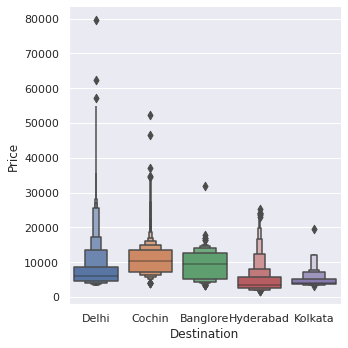

In [179]:
plt.figure(figsize=(15,15))
sns.catplot(x='Destination',y='Price',data=data.sort_values('Price',ascending=False),kind='boxen')

* From above plot we can say that flights going to Delhi will charge higher

In [180]:
Banglore= data[data['Destination']=='Banglore']
Delhi= data[data['Destination']=='Delhi']
Cochin= data[data['Destination']=='Cochin']
Hyderabad= data[data['Destination']=='Hyderabad']
Kolkata= data[data['Destination']=='Kolkata']

In [181]:
print(Banglore["Price"].mean())
print(Delhi["Price"].mean())
print(Cochin["Price"].mean())
print(Hyderabad["Price"].mean())
print(Kolkata["Price"].mean())

9158.389411354929
8017.464269458353
10540.113536155202
5061.0301724137935
4789.892388451443


* From the plot, we can see flight charges are a bit higher for any Airline going to Cochin when compared to other cities.

In [43]:
## Storing required categorical variables in cat_dat to apply dummification 
cat_data = ["Airline",'Source','Destination']

In [44]:
##Splitting Independent and dependent variable in X and Y respectively
X = data.drop(['Price'],axis=1)
Y = data[['Price']]

print(X.shape)
print(Y.shape)
print(type(X))

(10681, 12)
(10681, 1)
<class 'pandas.core.frame.DataFrame'>


In [45]:
# Splitting the dataset into the Training and Testing set.
X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size = 0.3, random_state = 42)

In [46]:
X_train = pd.get_dummies(X_train,columns=cat_data,drop_first= True)
X_val = pd.get_dummies(X_val,columns=cat_data,drop_first= True)

In [47]:
X_train.head()

,Total_Stops,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
6076,0,21,6,17,10,19,40,2,30,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2373,1,27,5,15,0,1,30,10,30,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
2442,1,5,9,22,40,10,40,12,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9822,1,5,9,6,20,10,20,4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8990,0,6,6,7,10,10,10,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [48]:
# Checking the shape
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(7476, 27)
(3205, 27)
(7476, 1)
(3205, 1)


In [49]:
## Scaling the data
sc=StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
y_train = sc.fit_transform(y_train)   ## Scaling the Target variable (contionous variable) 
y_val_scale = sc.transform(y_val)

In [51]:
scaler_Y = preprocessing.StandardScaler().fit(Y)

### Model performance check

* We will be using metric functions defined in sklearn for RMSE, MAE, and $R^2$.

* We will define functions to calculate adjusted $R^2$
* We will create a function that will print out all the above metrics in one go.

**Weight Initialization**

Weight initialization is an important consideration in the design of a neural network model.

The nodes in neural networks are composed of parameters referred to as weights used to calculate a weighted sum of the inputs.

Neural network models are fit using an optimization algorithm called stochastic gradient descent that incrementally changes the network weights to minimize a loss function, hopefully resulting in a set of weights for the mode that is capable of making useful predictions.

This optimization algorithm requires a starting point in the space of possible weight values from which to begin the optimization process. Weight initialization is a procedure to set the weights of a neural network to small random values that define the starting point for the optimization (learning or training) of the neural network model.

There are many WI techniques as follows:

1) Random normal initialization

2) Random Uniform initialization

3) Xaviour Initialization

4) He Initialization 


# Model Building

- We will now start with the model building process.
- We will create a model.
 - Three hidden layer with ReLU as activation function.
 - Output layer with 1 nodes (For regression problem )

In [182]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [183]:
model = Sequential()
model.add(Dense(64, activation='relu',kernel_initializer='he_uniform', input_shape=(27,)))
model.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))

In [184]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1792      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


**Observations**
- The summary of the model shows each layer's name, type, output shape, and the number of parameters at that particular layer.
- It also shows the total number of trainable and non-trainable parameters in the model. A parameter whose value is learned while training the model is called a trainable parameter otherwise it is called a non-trainable parameter.
- In the first layer total parameters are calculated by the number of neurons in the hidden layer multiplied by the number of variables fed to neural networks plus bias. (27*64)+64 = 1792
- In the next layer the parameters are calculated by the number of outputs from the previous layer multiplied by the number of neurons in the second layer plus bias. (64*32)+32 =2080
- You can calculate for the third layer and final layer.

In [185]:
optimizer = RMSprop( learning_rate=0.001)
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae'])
#es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val_scale), epochs=50)

Epoch 1/50
234/234 [==============================] - 1s 3ms/step - loss: 0.5221 - mae: 0.4884 - val_loss: 0.4156 - val_mae: 0.4300
Epoch 2/50
234/234 [==============================] - 1s 3ms/step - loss: 0.3674 - mae: 0.4159 - val_loss: 0.3599 - val_mae: 0.4329
Epoch 3/50
234/234 [==============================] - 1s 2ms/step - loss: 0.3228 - mae: 0.3904 - val_loss: 0.3235 - val_mae: 0.4082
Epoch 4/50
234/234 [==============================] - 1s 2ms/step - loss: 0.3033 - mae: 0.3783 - val_loss: 0.3083 - val_mae: 0.3875
Epoch 5/50
234/234 [==============================] - 1s 2ms/step - loss: 0.2913 - mae: 0.3673 - val_loss: 0.2897 - val_mae: 0.3869
Epoch 6/50
234/234 [==============================] - 1s 3ms/step - loss: 0.2799 - mae: 0.3613 - val_loss: 0.2930 - val_mae: 0.3843
Epoch 7/50
234/234 [==============================] - 1s 2ms/step - loss: 0.2709 - mae: 0.3549 - val_loss: 0.2705 - val_mae: 0.3679
Epoch 8/50
234/234 [==============================] - 1s 3ms/step - loss: 0.

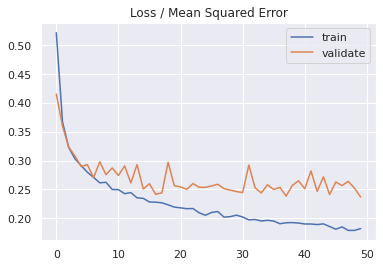

In [186]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()

* Here the model seems to be overfitted, as the distance between the train curve and validation curve started increasing. 

In [187]:
#Lets predict on validation data
Y_result_scaled= model.predict(X_val)
##As we have scaled the target variable, now after predicting we should inverse the scale and should convert to normal form
Y_result = scaler_Y.inverse_transform(Y_result_scaled) 
print(Y_result)

[[10960.869 ]
 [ 6385.642 ]
 [ 9585.967 ]
 ...
 [ 6977.1216]
 [14790.779 ]
 [ 6134.5493]]


In [190]:
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))
def model_performance_regression(predictors,target,pred):
  r2 = r2_score(target, pred)  # to compute R-squared
  adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
  rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
  mae = mean_absolute_error(target, pred)  # to compute MAE

  df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
        },
        index=[0],
    )

  return df_perf

In [191]:
# Checking model performance on train set
print("Training Performance\n")
model_train_perf = model_performance_regression(X_val,y_val, Y_result)
model_train_perf

Training Performance



,RMSE,MAE,R-squared,Adj. R-squared
0,2242.851983,1592.727512,0.761004,0.758973


* Now, let's try changing the optimizer to Adam and see if we can overcome the overfitting problem. 

#### Building the model with Adam Optimizer (Model-2)

**Early stopping:** 

During training, the model is evaluated on a holdout validation dataset after each epoch. If the performance of the model on the validation dataset starts to degrade or no improvement (e.g. loss begins to increase or accuracy begins to decrease), then the training process is stopped after the certian interations.The model at the time that training is stopped is then used and is known to have good generalization performance.

This procedure is called “early stopping” and is perhaps one of the oldest and most widely used forms of neural network regularization.

In [62]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [63]:
model_2 = Sequential()
model_2.add(Dense(64, activation='relu',kernel_initializer='he_uniform', input_shape=(27,)))
model_2.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model_2.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model_2.add(Dense(1, activation='linear'))

In [64]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1792      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [65]:
optimizer = Adam( learning_rate=0.001)
model_2.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae'])
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
history_2 = model_2.fit(X_train, y_train, validation_data=(X_val, y_val_scale), epochs=50,callbacks=es_cb)

Epoch 1/50
234/234 [==============================] - 2s 4ms/step - loss: 0.5284 - mae: 0.4975 - val_loss: 0.4703 - val_mae: 0.4427
Epoch 2/50
234/234 [==============================] - 1s 3ms/step - loss: 0.3804 - mae: 0.4234 - val_loss: 0.4457 - val_mae: 0.4198
Epoch 3/50
234/234 [==============================] - 1s 3ms/step - loss: 0.3465 - mae: 0.3973 - val_loss: 0.4135 - val_mae: 0.4176
Epoch 4/50
234/234 [==============================] - 1s 3ms/step - loss: 0.3236 - mae: 0.3859 - val_loss: 0.3761 - val_mae: 0.4006
Epoch 5/50
234/234 [==============================] - 1s 3ms/step - loss: 0.3050 - mae: 0.3734 - val_loss: 0.3655 - val_mae: 0.4028
Epoch 6/50
234/234 [==============================] - 1s 3ms/step - loss: 0.3011 - mae: 0.3684 - val_loss: 0.3646 - val_mae: 0.3768
Epoch 7/50
234/234 [==============================] - 1s 3ms/step - loss: 0.2900 - mae: 0.3589 - val_loss: 0.2743 - val_mae: 0.3782
Epoch 8/50
234/234 [==============================] - 1s 3ms/step - loss: 0.

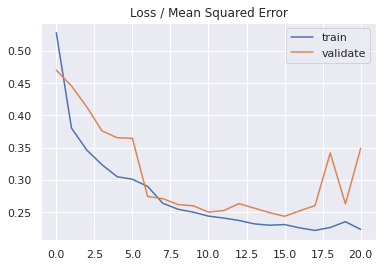

In [66]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history_2.history['loss'], label='train')
pyplot.plot(history_2.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()

*  After using Adam also, the model seems to be overfitted.

In [87]:
#Lets predict on validation data
Y_result_scaled_2= model_2.predict(X_val)
##As we have scaled the target variable, now after predicting we should inverse the scale and should convert to normal form
Y_result2 = scaler_Y.inverse_transform(Y_result_scaled_2) 
print(Y_result2)

[[ 9692.99  ]
 [ 5921.027 ]
 [ 9275.713 ]
 ...
 [ 7310.277 ]
 [15280.59  ]
 [ 6730.8203]]


In [89]:
# Checking model performance on train set
print("Training Performance\n")
model_train_perf = model_performance_regression(X_val,y_val, Y_result2)
model_train_perf

Training Performance



,RMSE,MAE,R-squared,Adj. R-squared
0,2721.786839,1664.253717,0.648036,0.645045


* After using Adam optimizer, the model seems to be overfitted. 
* Let's use two Regularization techniques to reduce the overfitting problem. 

 - Dropout 
 - BatchNormalization

#### Model-3

**Dropout**

Dropout is a regularization technique for neural network models proposed by Srivastava, et al. in their 2014 paper Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly.

In [90]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [91]:
model_3 = Sequential()
model_3.add(Dense(64, activation='relu',kernel_initializer='he_uniform', input_shape=(27,)))
model_3.add(Dropout(0.2))
model_3.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model_3.add(Dropout(0.1))
model_3.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model_3.add(Dense(1, activation='linear'))

In [92]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1792      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainabl

In [93]:
optimizer = Adam(0.001)
model_3.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae'])
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
history_3 = model_3.fit(X_train, y_train, validation_data=(X_val, y_val_scale), epochs=50,callbacks=es_cb)

Epoch 1/50
234/234 [==============================] - 2s 4ms/step - loss: 0.6781 - mae: 0.5965 - val_loss: 0.4780 - val_mae: 0.4621
Epoch 2/50
234/234 [==============================] - 1s 4ms/step - loss: 0.5253 - mae: 0.5215 - val_loss: 0.4265 - val_mae: 0.4437
Epoch 3/50
234/234 [==============================] - 1s 4ms/step - loss: 0.4609 - mae: 0.4856 - val_loss: 0.3762 - val_mae: 0.4322
Epoch 4/50
234/234 [==============================] - 1s 4ms/step - loss: 0.4289 - mae: 0.4693 - val_loss: 0.3454 - val_mae: 0.4058
Epoch 5/50
234/234 [==============================] - 1s 3ms/step - loss: 0.3951 - mae: 0.4458 - val_loss: 0.3305 - val_mae: 0.4042
Epoch 6/50
234/234 [==============================] - 1s 3ms/step - loss: 0.3838 - mae: 0.4374 - val_loss: 0.3234 - val_mae: 0.3941
Epoch 7/50
234/234 [==============================] - 1s 3ms/step - loss: 0.3632 - mae: 0.4259 - val_loss: 0.3436 - val_mae: 0.4196
Epoch 8/50
234/234 [==============================] - 1s 3ms/step - loss: 0.

#### Just by changing the optimizers we are able to reduce the loss to 19.25% and 22.16% for validation data 

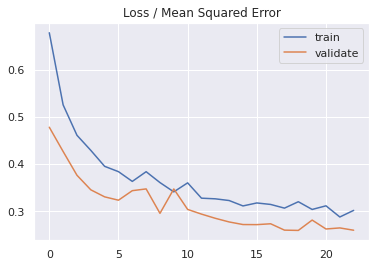

In [94]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history_3.history['loss'], label='train')
pyplot.plot(history_3.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()

* After using Dropout the both curves seems to be smooth

In [95]:
Y_result_scaled_3= model_3.predict(X_val)
Y_result_3 = scaler_Y.inverse_transform(Y_result_scaled_3)
print(Y_result_3)

[[ 8996.033 ]
 [ 6522.487 ]
 [10741.258 ]
 ...
 [ 6694.14  ]
 [13251.269 ]
 [ 5227.4443]]


In [96]:
r_squared_3 = r2_score(y_val, Y_result_3)
print('r2 = {}'.format(r_squared_3))

r2 = 0.7367894832760309


In [97]:
# Checking model performance on train set
print("Training Performance\n")
model_train_perf = model_performance_regression(X_val,y_val, Y_result_3)
model_train_perf

Training Performance



,RMSE,MAE,R-squared,Adj. R-squared
0,2353.731148,1693.015228,0.736789,0.734553


The Adjusted R-Square has increased when compared to the previous model. Now lets try BatchNormalization technique to improve the score. 

#### Model-4

In [98]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [99]:
model_4 = Sequential()
model_4.add(Dense(64, activation='relu',kernel_initializer='he_uniform', input_shape=(27,)))
model_4.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model_4.add(BatchNormalization())
model_4.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model_4.add(Dense(1, activation='linear'))

In [100]:
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1792      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,089
Trainable params: 5,025
Non-trainable params: 64
_____________________________________________________

In [101]:
optimizer = Adam(0.001)
model_4.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae'])
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
history_4 = model_4.fit(X_train, y_train, validation_data=(X_val, y_val_scale), epochs=50,callbacks=es_cb)

Epoch 1/50
234/234 [==============================] - 2s 5ms/step - loss: 0.6256 - mae: 0.5519 - val_loss: 0.6713 - val_mae: 0.4743
Epoch 2/50
234/234 [==============================] - 1s 4ms/step - loss: 0.4043 - mae: 0.4481 - val_loss: 0.6317 - val_mae: 0.4257
Epoch 3/50
234/234 [==============================] - 1s 3ms/step - loss: 0.3568 - mae: 0.4222 - val_loss: 0.4780 - val_mae: 0.4190
Epoch 4/50
234/234 [==============================] - 1s 4ms/step - loss: 0.3352 - mae: 0.4087 - val_loss: 0.5022 - val_mae: 0.4120
Epoch 5/50
234/234 [==============================] - 1s 4ms/step - loss: 0.3214 - mae: 0.3980 - val_loss: 0.4379 - val_mae: 0.4054
Epoch 6/50
234/234 [==============================] - 1s 3ms/step - loss: 0.3127 - mae: 0.3945 - val_loss: 0.4210 - val_mae: 0.3894
Epoch 7/50
234/234 [==============================] - 1s 3ms/step - loss: 0.2994 - mae: 0.3847 - val_loss: 0.3532 - val_mae: 0.4019
Epoch 8/50
234/234 [==============================] - 1s 4ms/step - loss: 0.

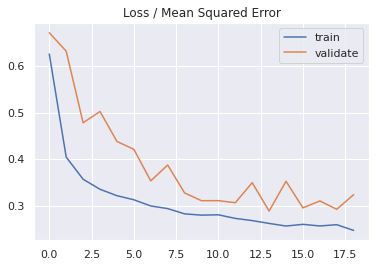

In [102]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history_4.history['loss'], label='train')
pyplot.plot(history_4.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()

* The gap between both the loss curves is somewhat high when compared to the previous model.

In [103]:
Y_result_scaled_4= model_4.predict(X_val)
Y_result_4 = scaler_Y.inverse_transform(Y_result_scaled_4)
print(Y_result_4)

[[ 9934.3955]
 [ 5936.3833]
 [ 9638.261 ]
 ...
 [ 6531.1704]
 [15186.242 ]
 [ 4904.089 ]]


In [104]:
r_squared_4 = r2_score(y_val, Y_result_4)
print('r2 = {}'.format(r_squared_4))

r2 = 0.6731821264752305


In [105]:
# Checking model performance on train set
print("Training Performance\n")
model_train_perf = model_performance_regression(X_val,y_val, Y_result_4)
model_train_perf

Training Performance



,RMSE,MAE,R-squared,Adj. R-squared
0,2622.757488,1659.662327,0.673182,0.670405


* BatchNormalization technique did not perform well on and even the Adjusted R-square has been decreased.
* Let's try to build another model using Dropout with different neural network architecture and see if we can increase the Adjusted R-square. 

### Model-5

In [121]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [122]:
model_5 = Sequential()
model_5.add(Dense(128, activation='relu',kernel_initializer='he_uniform', input_shape=(27,)))
model_5.add(Dropout(0.2))
model_5.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
model_5.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model_5.add(Dropout(0.1))
model_5.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model_5.add(Dense(1, activation='linear'))

In [123]:
model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3584      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 1)                 3

In [124]:
optimizer = Adam(0.001)
model_5.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae'])
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
history_5 = model_5.fit(X_train, y_train, validation_data=(X_val, y_val_scale), epochs=50,callbacks=es_cb)

Epoch 1/50
234/234 [==============================] - 2s 4ms/step - loss: 0.6716 - mae: 0.5798 - val_loss: 0.4126 - val_mae: 0.4400
Epoch 2/50
234/234 [==============================] - 1s 3ms/step - loss: 0.4588 - mae: 0.4758 - val_loss: 0.4268 - val_mae: 0.4189
Epoch 3/50
234/234 [==============================] - 1s 3ms/step - loss: 0.3957 - mae: 0.4478 - val_loss: 0.5432 - val_mae: 0.4276
Epoch 4/50
234/234 [==============================] - 1s 3ms/step - loss: 0.4064 - mae: 0.4334 - val_loss: 0.3244 - val_mae: 0.4243
Epoch 5/50
234/234 [==============================] - 1s 3ms/step - loss: 0.4241 - mae: 0.4276 - val_loss: 0.3018 - val_mae: 0.4096
Epoch 6/50
234/234 [==============================] - 1s 3ms/step - loss: 0.3645 - mae: 0.4179 - val_loss: 0.2869 - val_mae: 0.3927
Epoch 7/50
234/234 [==============================] - 1s 3ms/step - loss: 0.3543 - mae: 0.4090 - val_loss: 0.2889 - val_mae: 0.4067
Epoch 8/50
234/234 [==============================] - 1s 3ms/step - loss: 0.

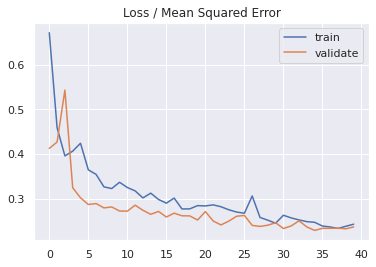

In [125]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history_5.history['loss'], label='train')
pyplot.plot(history_5.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()

* We can observe that after increasing the layers, both the curves seems to be smooth. 

In [127]:
Y_result_scaled_5= model_5.predict(X_val)
Y_result_5 = scaler_Y.inverse_transform(Y_result_scaled_5)
print(Y_result_5)

[[ 9806.362 ]
 [ 6759.6885]
 [ 8734.437 ]
 ...
 [ 6657.963 ]
 [13673.88  ]
 [ 6280.184 ]]


In [128]:
r_squared_5 = r2_score(y_val, Y_result_5)
print('r2 = {}'.format(r_squared_5))

r2 = 0.7605569651442672


In [129]:
# Checking model performance on train set
print("Training Performance\n")
model_train_perf = model_performance_regression(X_val,y_val, Y_result_5)
model_train_perf

Training Performance



,RMSE,MAE,R-squared,Adj. R-squared
0,2244.94828,1623.086807,0.760557,0.758522


* The Adjusted R-square of the model increased compared to the previous model, and the other metrics are also the best compared to all the previous models built. 

### Comments 

- We have trained 5 different models with some changes in architecture and Optimizer.
- Just by changing increasing one layer in the last model, we were able to reduce the loss.
- Play around with your neural network model by changing the number of dense layers, learning rate, number of neurons in hidden layers. Try out different loss and activation functions and see if you can get a better Adjusted R Square. 

### Happy Learning ! 